# Initialization

Run the following code to import the modules you'll need.

In [ ]:
import os
import numpy as np
import cv2
import skimage.color
import pickle
from matplotlib import pyplot as plt
import scipy
from skimage.util import montage
import time

PATCHWIDTH = 9

def read_pickle(path):
    with open(path, "rb") as f:
        return pickle.load(f)

def write_pickle(path, data):
    with open(path, "wb") as f:
        pickle.dump(data, f)

def briefMatch(desc1,desc2,ratio):

    matches = skimage.feature.match_descriptors(desc1,desc2,
                                                'hamming',
                                                cross_check=True,
                                                max_ratio=ratio)
    return matches

def plotMatches(img1,img2,matches,locs1,locs2):

    fig, ax = plt.subplots(nrows=1, ncols=1)
    img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
    plt.axis('off')
    skimage.feature.util.plot_matched_features(img1,                   # Positional argument 1: image0
        img2,                   # Positional argument 2: image1
        keypoints0=locs1,       # Required keyword argument for keypoints in image 0
        keypoints1=locs2,       # Required keyword argument for keypoints in image 1
        matches=matches,        # Required keyword argument for match indices
        ax=ax,                  # Required keyword argument for Matplotlib axis
        matches_color='r',      # Optional coloring
        only_matches=True)
    plt.show()
    return

def makeTestPattern(patchWidth, nbits):

    np.random.seed(0)
    compareX = patchWidth*patchWidth * np.random.random((nbits,1))
    compareX = np.floor(compareX).astype(int)
    np.random.seed(1)
    compareY = patchWidth*patchWidth * np.random.random((nbits,1))
    compareY = np.floor(compareY).astype(int)

    return (compareX, compareY)

def computePixel(img, idx1, idx2, width, center):

    halfWidth = width // 2
    col1 = idx1 % width - halfWidth
    row1 = idx1 // width - halfWidth
    col2 = idx2 % width - halfWidth
    row2 = idx2 // width - halfWidth
    # Compare normalized pixel values
    return 1 if img[int(center[0]+row1)][int(center[1]+col1)] < img[int(center[0]+row2)][int(center[1]+col2)] else 0

def computeBrief(img, locs):

    patchWidth = 9
    nbits = 256
    compareX, compareY = makeTestPattern(patchWidth,nbits)
    m, n = img.shape

    halfWidth = patchWidth//2

    locs = locs.astype(int)
    locs = np.array(list(filter(lambda x: halfWidth <= x[0] < m-halfWidth and halfWidth <= x[1] < n-halfWidth, locs)))
    desc = np.array([list(map(lambda x: computePixel(img, x[0], x[1], patchWidth, c), zip(compareX, compareY))) for c in locs])

    return desc, locs

def corner_detection(img, sigma):

    # fast method
    result_img = skimage.feature.corner_fast(img, n=PATCHWIDTH, threshold=sigma)
    locs = skimage.feature.corner_peaks(result_img, min_distance=1)
    return locs

def loadVid(path):

    # Create a VideoCapture object and read from input file
    # If the input is the camera, pass 0 instead of the video file name

    cap = cv2.VideoCapture(path)

    # get fps, width, and height
    fps = cap.get(cv2.CAP_PROP_FPS)
    width  = cap.get(cv2.CAP_PROP_FRAME_WIDTH)
    height = cap.get(cv2.CAP_PROP_FRAME_HEIGHT)

    # Append frames to list
    frames = []

    # Check if camera opened successfully
    if cap.isOpened()== False:
        print("Error opening video stream or file")

    # Read until video is completed
    while(cap.isOpened()):

        # Capture frame-by-frame
        ret, frame = cap.read()

        if ret:
            #Store the resulting frame
            frames.append(frame)
        else:
            break

    # When everything done, release the video capture object
    cap.release()
    frames = np.stack(frames)

    return frames, fps, width, height

# Download data

Download the required data and setup the results directory. If running on colab, DATA_PARENT_DIR must be <br> DATA_PARENT_DIR = '/content/' <br> <br> Otherwise, use the local directory of your choosing. Data will be downloaded to DATA_PARENT_DIR/hw3_data and a subdirectory DATA_PARENT_DIR/results will be created.

In [ ]:
# Only change this if you are running locally
# Default on colab: DATA_PARENT_DIR = '/content/'

# Data will be downloaded to DATA_PARENT_DIR/hw3_data
# A subdirectory DATA_PARENT_DIR/results will be created

DATA_PARENT_DIR = '/content/'

if not os.path.exists(DATA_PARENT_DIR):
  raise RuntimeError('DATA_PARENT_DIR does not exist: ', DATA_PARENT_DIR)

RES_DIR = os.path.join(DATA_PARENT_DIR, 'results')
if not os.path.exists(RES_DIR):
  os.mkdir(RES_DIR)
  print('made directory: ', RES_DIR)


#paths different files are saved to
# OPTIONAL:
# feel free to change if funning locally
ROT_MATCHES_PATH = os.path.join(RES_DIR, 'brief_rot_test.pkl')
ROT_INV_MATCHES_PATH = os.path.join(RES_DIR, 'ec_brief_rot_inv_test.pkl')
AR_VID_FRAMES_PATH = os.path.join(RES_DIR, 'q_3_1_frames.npy')
AR_VID_FRAMES_EC_PATH = os.path.join(RES_DIR, 'q_3_2_frames.npy')

HW3_SUBDIR = 'hw3_data'
DATA_DIR = os.path.join(DATA_PARENT_DIR, HW3_SUBDIR)
ZIP_PATH = DATA_DIR + '.zip'
if not os.path.exists(DATA_DIR):
  !wget 'https://www.andrew.cmu.edu/user/hfreeman/data/16720_spring/hw3_data.zip' -O $ZIP_PATH
  !unzip -qq $ZIP_PATH -d $DATA_PARENT_DIR

made directory:  /content/results
--2025-10-08 17:20:34--  https://www.andrew.cmu.edu/user/hfreeman/data/16720_spring/hw3_data.zip
Resolving www.andrew.cmu.edu (www.andrew.cmu.edu)... 128.2.42.53
Connecting to www.andrew.cmu.edu (www.andrew.cmu.edu)|128.2.42.53|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 36434294 (35M) [application/zip]
Saving to: ‘/content/hw3_data.zip’

/content/hw3_data.z 100%[===================>]  34.75M  1.17MB/s    in 31s     

2025-10-08 17:21:06 (1.10 MB/s) - ‘/content/hw3_data.zip’ saved [36434294/36434294]



# Computing Planar Homographies

##  Feature Detection and Matching

---




Detection Methodology Differences


Harris Corner Detector (Gradient-Based): The Harris detector is based on the idea of autocorrelation and is derived from image gradients. It uses a mathematical matrix called the structure tensor (H) to measure the change in image intensity when a window is shifted in any direction.It computes horizontal and vertical gradients and a "corner response" function R based on the determinant and trace of the Structure Tensor. A corner is detected if the intensity changes significantly in all directions. This method often requires initial image smoothing to compute stable derivatives.




FAST Detector (Intensity Comparison):It is a inntensity-based comparison of a central pixel against its circular neighborhood.It examines a circle of sixteen pixels around a candidate point, p. A point is classified as a corner if a contiguous segment of n pixels (here,n=12) are all significantly brighter than I
p
​
 +t or all significantly darker than I
p
​
 −t.



**Computational Performance:**
The main advantage of FAST is its speed.FAST achieves high speed by relying on simple pixel-wise comparisons and integer arithmetic. The core process is so efficient that the detector derived from machine learning (FAST-9) can fully process live video using less than 5% of the available processing time.

Harris is Slower: The Harris detector is computationally more expensive. It involves floating-point operations like computing image derivatives (via convolutions) and calculating the complex components of the structure tensor. By comparison, the Harris detector was shown to consume 115% of the processing budget for the same frame rate.

---

---

BRIEF (Binary Robust Independent Elementary Features) descriptor differs from a filterbank-based descriptor primarily in its data type and computational method.

Differences in Descriptor Design
Data Type and Representation:

BRIEF is a binary descriptor, representing a feature patch as a string of 1s and 0s.

Filterbank descriptors are typically real-valued vectors of floating-point numbers.

Feature Extraction Method:

BRIEF avoids complex mathematical operations by using intensity comparisons between randomly sampled pixel pairs within the patch.

Filterbanks rely on convolution of the image patch with a bank of kernels (filters), which are tuned to specific orientations, scales, or frequencies.

Matching Metric:

BRIEF uses the Hamming distance for matching, which is calculated by counting the number of bits that differ between two strings.

Filterbank descriptors typically use the Euclidean distance or L2 norm.

Computational Cost:

BRIEF is extremely fast because it relies solely on simple bitwise and integer operations, which are much quicker than floating-point math.

Filterbank extraction has a higher cost due to the multiplication and summation required for convolutions.

**Usage of Filterbanks as Descriptors**:
Yes, we could use any of those filterbanks as a descriptor.

A descriptor's role is to summarize the local image appearance in a distinctive and stable manner. Since filterbanks (such as those based on Gaussian derivatives) are specifically designed to measure structural properties like texture and gradient orientation, the vector of responses to these filters serves as an effective,  usually high-dimensional and computationally expensive, feature descriptor.

---

---


The BRIEF descriptor uses the Hamming distance and Nearest Neighbor search for matching due to the descriptor's binary nature

Matching with BRIEF Descriptors
1. Hamming Distance

The distance between two BRIEF descriptors is calculated by counting the number of positions at which the corresponding bits are different. This is achieved in computers by performing a bitwise XOR operation between the two binary strings, and then performing a population count

Similarity: A smaller Hamming distance indicates a higher similarity between the two image patches represented by the binary descriptors.

2. Nearest Neighbor (NN) Matching
The Nearest Neighbor approach uses the Hamming distance to find the best match for every feature:

Search: For each BRIEF descriptor in the first image (I1
​), the Hamming distance is calculated to every descriptor in the second image (I2).

Best Match: The descriptor in I2
   that yields the minimum Hamming distance is designated as the Nearest Neighbor (NN) match.

Ratio Test: To reject ambiguous matches, a ratio test is often applied. This involves finding the distance to the Nearest Neighbor and the Second Nearest Neighbor. If the ratio
   is less than a specified threshold (ratio), the match is considered unique and valid.

Benefits of Hamming Distance

Computational Speedup: It can be calculated extremely fast using simple bitwise XOR operations. In contrast, Euclidean distance requires numerous floating-point multiplications, additions, and a square root, which are much slower. This efficiency is critical for applications like real-time tracking (SLAM).

Memory Efficiency: Since binary descriptors are compact, the lower memory access contributes to faster processing.

Appropriate Metric: Hamming distance is the appropriate metric for comparing binary data, as it directly counts the number of disagreements between the two sequences. Using Euclidean distance on binary (0, 1) vectors is theoretically equivalent to the square root of the Hamming distance, but it is computationally inefficient for this data type.

---

#### Implement the function matchPics()

In [ ]:
def matchPics(I1, I2, ratio, sigma):
    """
    Match features across images

    Input
    -----
    I1, I2: Source images (RGB or Grayscale uint8)
    ratio: ratio for BRIEF feature descriptor
    sigma: threshold for corner detection using FAST feature detector

    Returns
    -------
    matches: List of indices of matched features across I1, I2 [p x 2]
    locs1, locs2: Pixel coordinates of matches [N x 2]
    """

    # ===== your code here! =====

    # TODO: Convert images to GrayScale
    # Input images can be either RGB or Grayscale uint8 (0 -> 255). Both need
    # to be supported.
    # Input images must be converted to normalized Grayscale (0.0 -> 1.0)
    # skimage.color.rgb2gray may be useful if the input is RGB.
    if len(I1.shape) == 3:
        I1_gray = skimage.color.rgb2gray(I1)
    else:
        # Normalize if already grayscale
        I1_gray = I1 / 255.0

    if len(I2.shape) == 3:
        I2_gray = skimage.color.rgb2gray(I2)
    else:
        I2_gray = I2 / 255.0

    # TODO: Detect features in both images
    locs1 = corner_detection(I1_gray, sigma)
    locs2 = corner_detection(I2_gray, sigma)



    # TODO: Obtain descriptors for the computed feature locations
    desc1, locs1 = computeBrief(I1_gray, locs1)
    desc2, locs2 = computeBrief(I2_gray, locs2)


    # TODO: Match features using the descriptors
    matches = briefMatch(desc1, desc2, ratio)


    # ==== end of code ====

    return matches, locs1, locs2

#### Implement the function displayMatched

In [ ]:
def displayMatched(I1, I2, ratio, sigma):
    """
    Displays matches between two images

    Input
    -----
    I1, I2: Source images
    ratio: ratio for BRIEF feature descriptor
    sigma: threshold for corner detection using FAST feature detector
    """

    print('Displaying matches for ratio: ', ratio, ' and sigma: ', sigma)

    # ===== your code here! =====
    # TODO: Use matchPics and plotMatches to visualize your results
    matches, locs1, locs2 = matchPics(I1, I2, ratio, sigma)
    print(f"Total Matches Found: {matches.shape[0]}")

    plotMatches(I1, I2, matches, locs1, locs2)

    # ==== end of code ====

#### Visualize the matches

Use the cell below to visualize the matches. The resulting figure should look similar (but not necessarily identical) to Figure 2.

Feel free to play around with the images and parameters. Please use the original images when submitting the report.

Figure 2 parameters:

*   image1_name = "cv_cover.jpg"
*   image1_name = "cv_desk.png"
*   ratio = 0.7
*   sigma = 0.15

Displaying matches for ratio:  0.7  and sigma:  0.15


/tmp/ipython-input-5728546.py:65: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return 1 if img[int(center[0]+row1)][int(center[1]+col1)] < img[int(center[0]+row2)][int(center[1]+col2)] else 0


Total Matches Found: 24


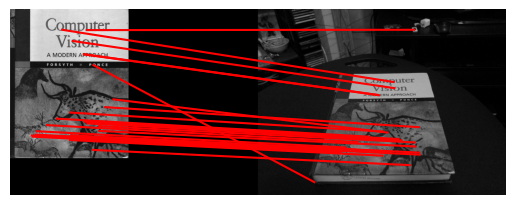

In [ ]:
# Feel free to play around with these parameters
# BUT when submitting the report use the original images
image1_name = "cv_cover.jpg"
image2_name = "cv_desk.png"
ratio = 0.7
sigma = 0.15

image1_path = os.path.join(DATA_DIR, image1_name)
image2_path = os.path.join(DATA_DIR, image2_name)

image1 = cv2.imread(image1_path)
image2 = cv2.imread(image2_path)

#bgr to rgb
if len(image1.shape) == 3 and image1.shape[2] == 3:
  image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)

if len(image2.shape) == 3 and image2.shape[2] == 3:
  image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)

displayMatched(image1, image2, ratio, sigma)

---


 As seen from the scenes below:

 1. When we decrease ratio, (0.7 to 0.5) keeping sigma constant=0.15, the number of matches decreases to 3. This is because it requires the best match to be significantly better  than the second-best match. So, the distance to the best match is significantly lesser than the second best match

 2. When we increase ratio, (0.7 to 1.2) keeping sigma constant=0.15, the number of matches increases to 215. This is because the best match is not significantly better  than the second-best match. So, the distance to the best match is comparable to the second best match

 3.When we decrease sigma, (0.15 to 0.1) keeping ratio constant=0.7, the number of matches increases to 64. This is because as the threshold value decreases, the number of rejected candidates for corners decreases and matches increases and when we increase threshold value sigma to 0.4, the case is reversed and matches reduced to  4.

 When we increase both, ratio=1.2,sigma=0.4, the matches equals to 33


---

Displaying matches for ratio:  0.5  and sigma:  0.15


/tmp/ipython-input-5728546.py:65: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return 1 if img[int(center[0]+row1)][int(center[1]+col1)] < img[int(center[0]+row2)][int(center[1]+col2)] else 0


Total Matches Found: 3


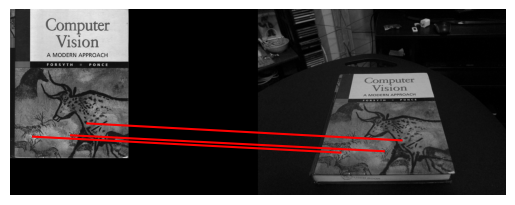

Displaying matches for ratio:  1.2  and sigma:  0.15
Total Matches Found: 215


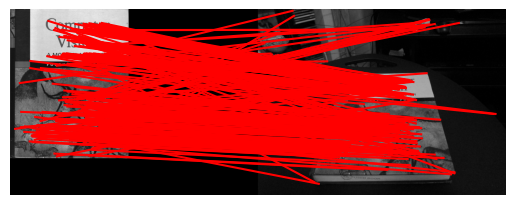

Displaying matches for ratio:  0.7  and sigma:  0.1
Total Matches Found: 64


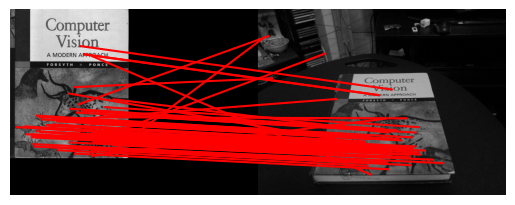

Displaying matches for ratio:  0.7  and sigma:  0.4
Total Matches Found: 4


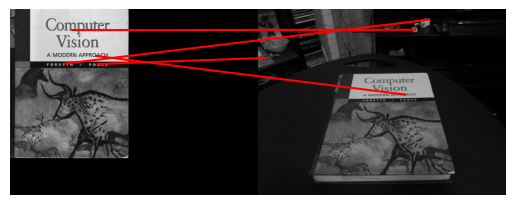

Displaying matches for ratio:  1.2  and sigma:  0.4
Total Matches Found: 33


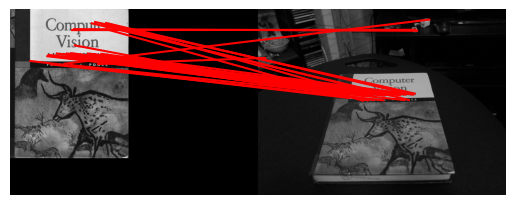

In [ ]:
image1_name = "cv_cover.jpg"
image2_name = "cv_desk.png"
ratio = 0.7
sigma = 0.15
image1_path = os.path.join(DATA_DIR, image1_name)
image2_path = os.path.join(DATA_DIR, image2_name)

image1 = cv2.imread(image1_path)
image2 = cv2.imread(image2_path)

#bgr to rgb
if len(image1.shape) == 3 and image1.shape[2] == 3:
  image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)

if len(image2.shape) == 3 and image2.shape[2] == 3:
  image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)

# ===== your code here! =====
# Experiment with different sigma and ratio values.
# Use displayMatches to visualize.
# Include the matched feature figures in the write-up.
ablation_parameters = [

    {'ratio': 0.5, 'sigma': 0.15},
    {'ratio': 1.2, 'sigma': 0.15},

    {'ratio': 0.7, 'sigma': 0.1},
    {'ratio': 0.7, 'sigma': 0.4},
    {'ratio': 1.2, 'sigma': 0.4},
]


for params in ablation_parameters:
    ratio = params['ratio']
    sigma = params['sigma']

    displayMatched(image1, image2, ratio, sigma)

# ==== end of code ====

#### Implement the function briefRot

In [ ]:
def briefRot(min_deg, max_deg, deg_inc, ratio, sigma, filename):
    """
    Tests Brief with rotations.

    Input
    -----
    min_deg: minimum degree to rotate image
    max_deg: maximum degree to rotate image
    deg_inc: number of degrees to increment when iterating
    ratio: ratio for BRIEF feature descriptor
    sigma: threshold for corner detection using FAST feature detector
    filename: filename of image to rotate

    """

    if not os.path.exists(RES_DIR):
      raise RuntimeError('RES_DIR does not exist. did you run all cells?')

    # Read the image and convert bgr to rgb
    image_path = os.path.join(DATA_DIR, filename)
    image = cv2.imread(image_path)
    if len(image.shape) == 3 and image.shape[2] == 3:
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    match_degrees = [] # stores the degrees of rotation
    match_counts = [] # stores the number of matches at each degree of rotation

    for i in range(min_deg, max_deg, deg_inc):
        print(i)

        # ===== your code here! =====
        # TODO: Rotate Image (Hint: use scipy.ndimage.rotate)
        rotated = scipy.ndimage.rotate(image, i, reshape=False)


        # TODO: Match features in images
        matches, locs1, locs2 = matchPics(image, rotated, ratio, sigma)

        # TODO: visualizes matches at at least 3 different orientations
        # to include in your report
        # (Hint: use plotMatches)
        if i in [0, 90, 180]:   # can change which 3 orientations to show
            print(f"Matches at rotation {i}°")
            plotMatches(image, rotated, matches, locs1, locs2)
            plt.title(f"Matches at rotation {i}°")

        # TODO: Update match_degrees and match_counts (see descriptions above)
        match_degrees.append(i)
        match_counts.append(matches.shape[0])

        # ==== end of code ====

    # Save to pickle file
    matches_to_save = [match_counts, match_degrees, deg_inc]
    write_pickle(ROT_MATCHES_PATH, matches_to_save)

def dispBriefRotHist(matches_path=ROT_MATCHES_PATH):
    # Check if pickle file exists
    if not os.path.exists(matches_path):
      raise RuntimeError('matches_path does not exist. did you call briefRot?')

    # Read from pickle file
    match_counts, match_degrees, deg_inc = read_pickle(matches_path)

    # Display histogram
    # Bins are centered and separated every 10 degrees
    plt.figure()
    bins = [x - deg_inc/2 for x in match_degrees]
    bins.append(bins[-1] + deg_inc)
    plt.hist(match_degrees, bins=bins, weights=match_counts, log=True)
    #plt.hist(match_degrees, bins=[10 * (x-0.5) for x in range(37)], weights=match_counts, log=True)
    plt.title("Histogram of BREIF matches")
    plt.ylabel("# of matches")
    plt.xlabel("Rotation (deg)")
    plt.tight_layout()

    output_path = os.path.join(RES_DIR, 'histogram.png')
    plt.savefig(output_path)

#### Visualize the matches under rotation

See debugging tips in handout.


0


/tmp/ipython-input-5728546.py:65: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return 1 if img[int(center[0]+row1)][int(center[1]+col1)] < img[int(center[0]+row2)][int(center[1]+col2)] else 0


Matches at rotation 0°


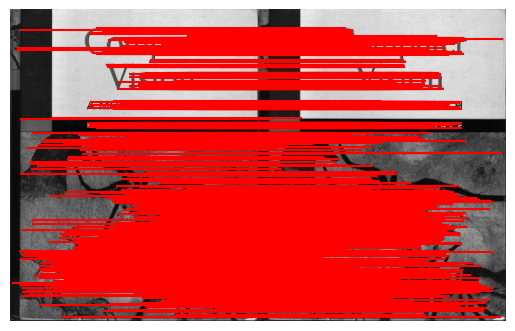

10
20
30
40
50
60
70
80
90
Matches at rotation 90°


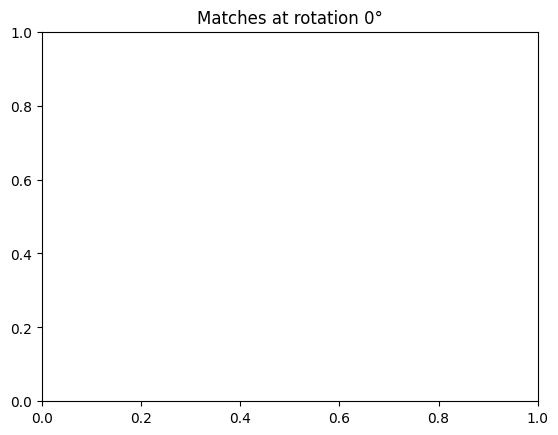

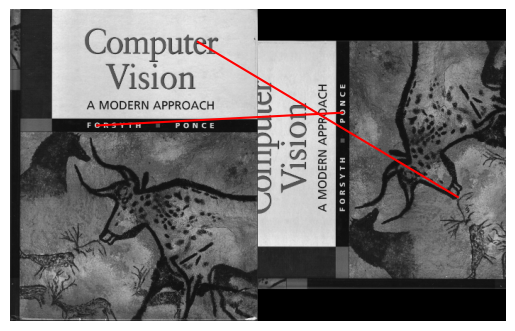

100
110
120
130
140
150
160
170
180
Matches at rotation 180°


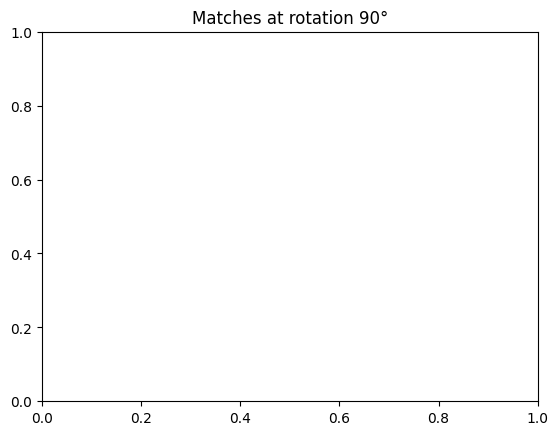

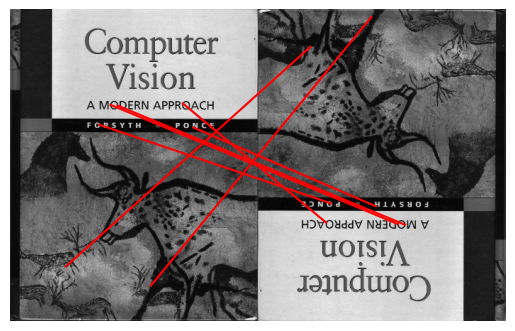

190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350


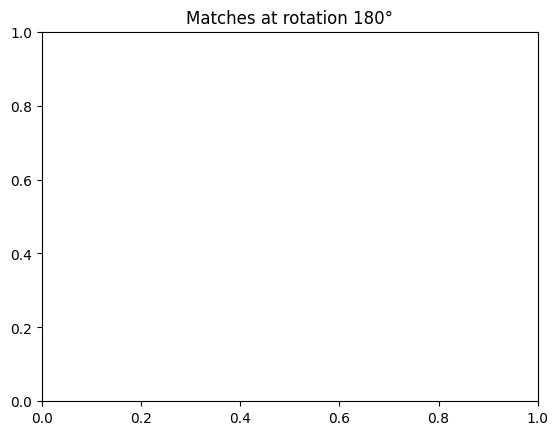

In [ ]:
# defaults are:
# min_deg = 0
# max_deg = 360
# deg_inc = 10
# ratio = 0.7
# sigma = 0.15
# filename = 'cv_cover.jpg'

# Controls the rotation degrees
min_deg = 0
max_deg = 360
deg_inc = 10

# Brief feature descriptor and Fast feature detector paremeters
# (change these if you want to use different values)
ratio = 0.7
sigma = 0.15

# image to rotate and match
# (no need to change this but can if you want to experiment)
filename = 'cv_cover.jpg'

# Call briefRot
briefRot(min_deg, max_deg, deg_inc, ratio, sigma, filename)

#### Plot the histogram

See debugging tips in handout.

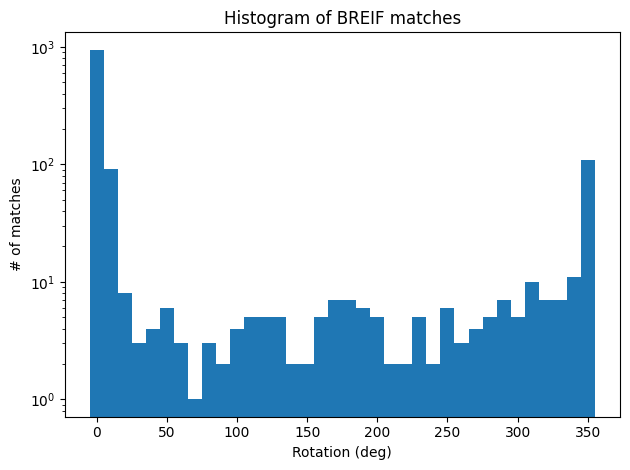

In [ ]:
dispBriefRotHist()




The histogram shows the distribution of matched keypoints across different rotation angles:

Dominant Peak at 0 degree
  (and 360 degree):

The BRIEF descriptor performs well when there is no rotation because it's calculated by comparing the intensity of fixed pixel pairs within a patch. When the patch is not rotated, these fixed pixel comparisons remain valid.

As the rotation angle increases (moving away from 0 degree and 360 degree), the number of matches drops.

The BRIEF descriptor is not rotation-invariant. When a keypoint patch is rotated, the fixed pair of pixels used for the binary test also rotates relative to the image coordinates. This fundamentally changes the binary sequence (the descriptor), making it very different from the descriptor calculated at 0 degree
 .

For example, a 90 degree
  rotation causes the descriptor to become almost entirely uncorrelated with the original descriptor, leading to very few valid matches.



Between approximately 50 degree
  and 300 degree
 , the match count is low (mostly 1 to 10) and scattered.These few matches are likely accidental matches, or matches where the local image texture is simple.

###

Design a fix to make BRIEF more rotation invariant. Feel free to make any helper functions as necessary. But you cannot use any additional OpenCV or Scikit-Image functions.

In [ ]:
import os
for path in [
    "cv_cover.jpg",
    "hw3_data/cv_cover.jpg",
    "./data/cv_cover.jpg",
    "../data/cv_cover.jpg"
]:
    print(path, "->", os.path.exists(path))

cv_cover.jpg -> False
hw3_data/cv_cover.jpg -> True
./data/cv_cover.jpg -> False
../data/cv_cover.jpg -> False


In [ ]:
# ===== your code here! =====
from math import ceil, cos, sin, radians, atan2, degrees
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
from scipy.ndimage import rotate
from scipy.spatial.distance import cdist

# --- GLOBAL CONSTANTS & HELPERS ---
PATCH_SIZE = 31


def computeSobelGradients(img_8u):
    """MANUALLY computes Sobel gradients """
    img = img_8u.astype(np.float32)
    h, w = img.shape
    sobel_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], dtype=np.float32)
    sobel_y = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]], dtype=np.float32)
    Ix = np.zeros_like(img); Iy = np.zeros_like(img)
    for i in range(1, h - 1):
        for j in range(1, w - 1):
            patch = img[i-1:i+2, j-1:j+2]
            Ix[i, j] = np.sum(patch * sobel_x)
            Iy[i, j] = np.sum(patch * sobel_y)
    return Ix, Iy


def briefRotInvEc(min_deg, max_deg, deg_inc, ratio, sigma, filename):

    if not os.path.exists(RES_DIR):
        os.makedirs(RES_DIR)


    img_bgr = cv2.imread(filename)
    if img_bgr is None: raise FileNotFoundError(f"Could not load {filename}")

    img_gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    img_rgb_vis = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    img_float = img_gray.astype(np.float32)
    img_8u = img_gray.astype(np.uint8)

    Ix, Iy = computeSobelGradients(img_8u)
    locs = corner_detection(img_8u, sigma)

    orientations = []; half = PATCH_SIZE // 2; h, w = img_float.shape

    # [Orientation calculation loop]
    for (y, x) in locs:
        x_int, y_int = int(x), int(y)
        if x_int < half or x_int >= w - half or y_int < half or y_int >= h - half:
            orientations.append(0.0); continue

        patch_Ix = Ix[y_int - half : y_int + half + 1, x_int - half : x_int + half + 1]
        patch_Iy = Iy[y_int - half : y_int + half + 1, x_int - half : x_int + half + 1]
        m10 = np.sum(patch_Ix); m01 = np.sum(patch_Iy)
        angle = np.degrees(np.arctan2(m01, m10)) if (m10 != 0 or m01 != 0) else 0
        orientations.append(angle)

    orientations = np.array(orientations)

    # Compute descriptors for Image 1
    desc_list = []; locs_final = []
    for i, ((y_float, x_float), angle) in enumerate(zip(locs, orientations)):
        y_int, x_int = int(y_float), int(x_float)
        patch = img_8u[max(0, y_int - half):min(h, y_int + half + 1), max(0, x_int - half):min(w, x_int + half + 1)]
        if patch.shape[0] < PATCH_SIZE or patch.shape[1] < PATCH_SIZE: continue

        rot_patch = rotate(patch, -angle, reshape=False).astype(np.uint8)
        desc, _ = computeBrief(rot_patch, np.array([[half, half]]))

        if desc.size > 0:
            desc_list.append(desc[0]);
            locs_final.append([x_int, y_int])

    desc1 = np.array(desc_list); locs1 = np.array(locs_final)

    #  Loop through Rotations and Match
    match_counts, match_degrees = [], []
    for deg in range(min_deg, max_deg + 1, deg_inc):

        img_rot_raw = rotate(img_float, deg, reshape=False)
        img_rot = img_rot_raw.astype(np.uint8)

        # Recalculate gradients and orientation for the rotated image
        Ix_rot, Iy_rot = computeSobelGradients(img_rot)
        locs2_all = corner_detection(img_rot, sigma)

        orientations2 = []
        for (y, x) in locs2_all:
            x_int, y_int = int(x), int(y)
            if x_int < half or x_int >= w - half or y_int < half or y_int >= h - half:
                orientations2.append(0.0); continue
            m10 = np.sum(Ix_rot[y_int - half : y_int + half + 1, x_int - half : x_int + half + 1])
            m01 = np.sum(Iy_rot[y_int - half : y_int + half + 1, x_int - half : x_int + half + 1])
            angle = np.degrees(np.arctan2(m01, m10)) if (m10 != 0 or m01 != 0) else 0
            orientations2.append(angle)

        # Compute Descriptors for Image 2
        locs2 = []; desc2_list = []
        for i, ((y_float, x_float), angle) in enumerate(zip(locs2_all, orientations2)):
             y_int, x_int = int(y_float), int(x_float)
             patch_rot = img_rot[max(0, y_int - half):min(h, y_int + half + 1), max(0, x_int - half):min(w, x_int + half + 1)]
             if patch_rot.shape[0] < PATCH_SIZE or patch_rot.shape[1] < PATCH_SIZE: continue

             rot_patch = rotate(patch_rot, -angle, reshape=False).astype(np.uint8)
             desc2_raw, _ = computeBrief(rot_patch, np.array([[half, half]]))

             if desc2_raw.size > 0:
                 desc2_list.append(desc2_raw[0])
                 locs2.append([x_int, y_int])

        desc2 = np.array(desc2_list); locs2 = np.array(locs2)

        if desc1.size == 0 or desc2.size == 0 or desc1.shape[1] != desc2.shape[1]:
            matches = np.zeros((0, 2))
        else:

            matches = briefMatch(desc1, desc2, ratio)


        match_counts.append(matches.shape[0])
        match_degrees.append(deg)

        if deg in [min_deg, (min_deg + max_deg)//2, 90]:
            img_rot_rgb = cv2.cvtColor(img_rot, cv2.COLOR_GRAY2RGB)
            plotMatches(img_rgb_vis, img_rot_rgb, matches, locs1, locs2)

            plt.title(f'Rotation-Invariant Matches at {deg}°')
            plt.savefig(os.path.join(RES_DIR, f'briefRotInv_{deg}.png'))
            plt.close()

    # Final logic
    # write_pickle('ec_brief_rot_inv_test.pkl', [match_counts, match_degrees, deg_inc])
    plt.figure()
    plt.bar(match_degrees, match_counts, width=deg_inc*0.8)
    plt.xlabel('Rotation (degrees)')
    plt.ylabel('Number of Matches')
    plt.title('Rotation-Invariant BRIEF Histogram')
    plt.savefig(os.path.join(RES_DIR, 'histogram_briefRotInv.png'))
    plt.close()

    return match_degrees, match_counts

#### Visualize your implemented function


Starting Rotation-Invariant BRIEF analysis...


/tmp/ipython-input-5728546.py:65: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return 1 if img[int(center[0]+row1)][int(center[1]+col1)] < img[int(center[0]+row2)][int(center[1]+col2)] else 0


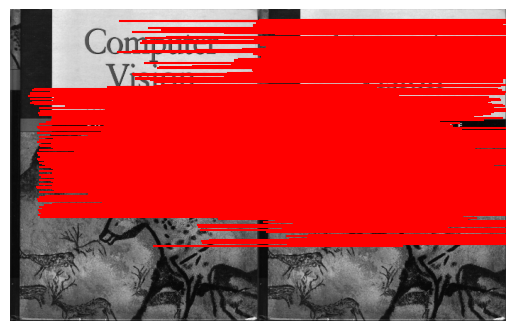

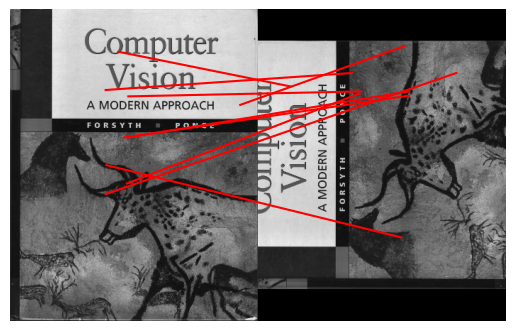

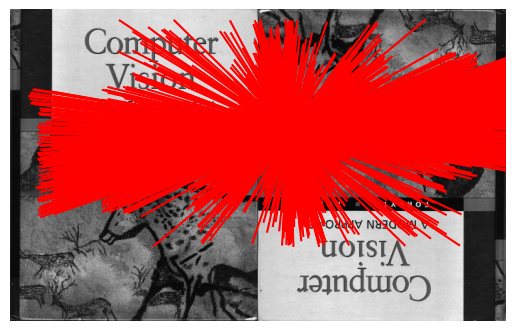

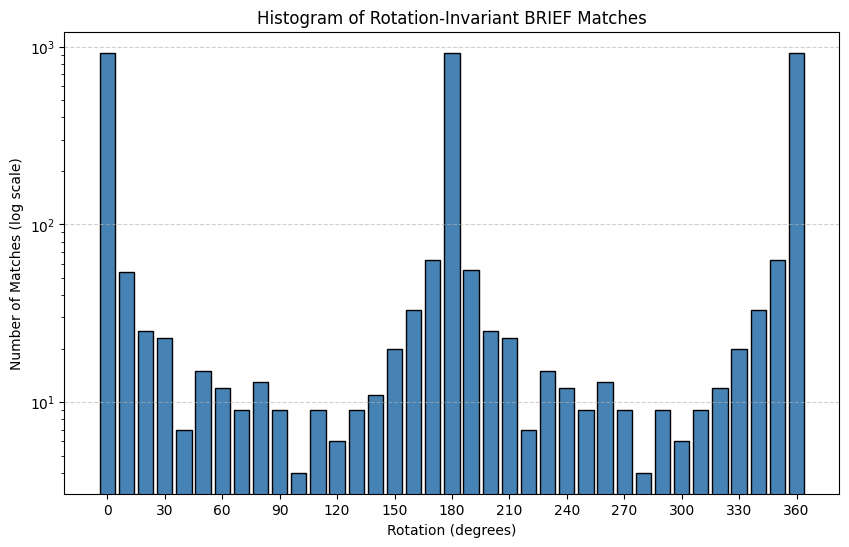

Histogram demonstrating rotation invariance saved to:
results/brief_rot_inv_histogram.png


In [ ]:
min_deg = 0
max_deg = 360
deg_inc = 10
filename = 'hw3_data/cv_cover.jpg'

# ===== your code here! =====
# TODO: Call briefRotInvEc and visualize
print("Starting Rotation-Invariant BRIEF analysis...")

degrees, counts = briefRotInvEc(min_deg, max_deg, deg_inc, ratio, sigma, filename)



plt.figure(figsize=(10, 6))
plt.bar(degrees, counts, width=deg_inc * 0.8, align='center', color='steelblue', edgecolor='black')

plt.yscale('log')
plt.title('Histogram of Rotation-Invariant BRIEF Matches')
plt.xlabel('Rotation (degrees)')
plt.ylabel('Number of Matches (log scale)')
plt.xticks(np.arange(0, 361, 30))
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Save and show
histogram_path = os.path.join(RES_DIR, 'brief_rot_inv_histogram.png')
plt.savefig(histogram_path, bbox_inches='tight')
plt.show()

print(f"Histogram demonstrating rotation invariance saved to:\n{histogram_path}")

# ==== end of code ====


#### Plot Histogram

In [ ]:
dispBriefRotHist(matches_path=ROT_INV_MATCHES_PATH)

RuntimeError: matches_path does not exist. did you call briefRot?

---



As can be seen from the histograms (included with the visualization code) of without rotation-invariant and rotation-invariant histograms, the second one increases significantly the number of matches at all angles. Though the number of matches is not equal in all types of rotation but still each number increases significantly.
The central design goal was to make the standard BRIEF descriptor invariant to in-plane rotation  without relying on external libraries like OpenCV's ORB. This was achieved by adopting three main steps:

Orientation Calculation : We calculate the unique dominant angle (α) of the feature patch. This is done by analyzing the image gradients (I
x
​
  and I
y
​
 ) within the patch, treating the gradients as mass. The angle of the vector formed by the sum of moments, atan2(∑I
y
​
 ,∑I
x
​
 ), gives the feature's orientation.

Patch Alignment: Before computing the descriptor, the image patch is geometrically rotated by the negative of the calculated orientation (−α) using scipy.ndimage.rotate. This process aligns the feature to a standard, axis-aligned state.

Descriptor Computation: The standard BRIEF sampling pattern is applied to this newly aligned, canonical patch. Because the patch is always sampled from the same perspective, the resulting binary descriptor string remains consistent even when the original image is rotated.

**Parameters**

I used Patchsize=31 because that is the standard dimension used in ORB algorithm.

I used Kernel of 3x3 because it provide a robust measure of intensity change direction, which is essential for accurate orientation calculation.

The FAST corner threshold and matching ratio ,are given according to earlier performances.

---

###

Design a fix to make BRIEF more scale invariant. Feel free to make any helper functions as necessary. But you cannot use any additional OpenCV or Scikit-Image functions.


In [ ]:
import os
print("Current working directory:", os.getcwd())
print("Files in directory:", os.listdir())

Current working directory: /content
Files in directory: ['.config', 'results', 'hw3_data', 'hw3_data.zip', 'sample_data']


In [ ]:

# ===== your code here! =====

from skimage.transform import rescale
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

# --- GLOBAL CONSTANTS ---
PATCH_SIZE = 31
NUM_OCTAVES = 4
SCALE_FACTOR = 1.414
DESC_LENGTH = 32



def briefScaleInvEc(ratio, sigma, filename, min_scale=0.5, max_scale=2.0, num_steps=9):

    if not os.path.exists(RES_DIR):
        os.makedirs(RES_DIR)


    image_path = os.path.join(DATA_DIR, filename)
    img_bgr = cv2.imread(image_path)
    if img_bgr is None: raise FileNotFoundError(f"Could not load {filename}")

    img_A_gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY).astype(np.float32)
    img_A_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    img_8u = img_A_gray.astype(np.uint8)

    locs_A_pyramid = []
    desc_A_pyramid = []


    for octave in range(NUM_OCTAVES):
        scale = SCALE_FACTOR ** octave
        resize_factor = 1.0 / scale


        img_level_raw = cv2.resize(img_8u, (0, 0), fx=resize_factor, fy=resize_factor)
        img_level = img_level_raw.astype(np.float32)

        sigma_scaled = sigma * scale


        locs_level = corner_detection(img_level_raw, sigma_scaled)


        locs_level_filtered, desc_level = computeBrief(img_level, locs_level)

        if desc_level.shape[0] > 0:

            locs_original_scale = locs_level_filtered * scale

            locs_A_pyramid.append(locs_original_scale)
            desc_A_pyramid.append(desc_level)

    locs_A_final = np.concatenate(locs_A_pyramid, axis=0) if locs_A_pyramid else np.zeros((0, 2))
    desc_A_final = np.concatenate(desc_A_pyramid, axis=0) if desc_A_pyramid else np.zeros((0, DESC_LENGTH), dtype=np.uint8)

    if locs_A_final.shape[0] < 4:
        print("Warning: Insufficient scale-invariant features detected. Cannot proceed.")
        return [], [], []


    match_scales = []; match_counts_scale_inv = []; match_counts_orig = []
    scales_to_test = np.linspace(min_scale, max_scale, num_steps)

    for current_scale in scales_to_test:


        W_new = int(img_A_gray.shape[1] * current_scale)
        H_new = int(img_A_gray.shape[0] * current_scale)

        img_B_raw = cv2.resize(img_8u, (W_new, H_new), interpolation=cv2.INTER_AREA)
        img_B_rgb = cv2.resize(img_A_rgb, (W_new, H_new), interpolation=cv2.INTER_AREA)

        locs_B = corner_detection(img_B_raw, sigma)
        locs_B_proc, desc_B = computeBrief(img_B_raw.astype(np.float32), locs_B) # Assume simpler helper call


        if desc_B.shape[0] > 0 and desc_A_final.shape[1] == desc_B.shape[1]:

             matches_scale_inv = briefMatch(desc_A_final, desc_B, ratio)
             count_inv = len(matches_scale_inv)
        else:
            count_inv = 0
            matches_scale_inv = np.zeros((0, 2), dtype=int)


        matches_orig, locs1_orig, locs2_orig = matchPics(img_A_rgb, img_B_rgb, ratio, sigma)

        match_counts_scale_inv.append(count_inv)
        match_counts_orig.append(len(matches_orig))
        match_scales.append(current_scale)


        if np.isclose(current_scale, 0.5) or np.isclose(current_scale, 1.0) or np.isclose(current_scale, 1.5):
            print(f'Plotting scale-invariant at scale: {current_scale:.2f}')

            plotMatches(img_A_rgb, img_B_rgb, matches_scale_inv, locs_A_final, locs_B)



    return match_scales, match_counts_scale_inv, match_counts_orig

#### Visualize your implemented function

Running briefScaleInvEc... (this may take a few minutes)


/tmp/ipython-input-5728546.py:65: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return 1 if img[int(center[0]+row1)][int(center[1]+col1)] < img[int(center[0]+row2)][int(center[1]+col2)] else 0


Plotting scale-invariant at scale: 0.50


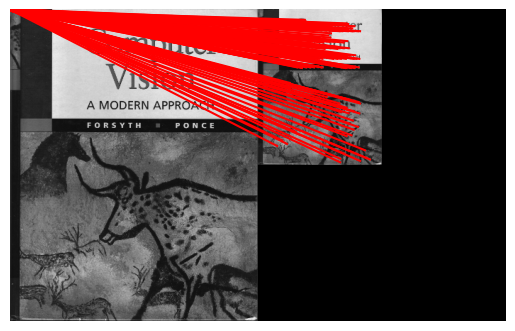

Plotting scale-invariant at scale: 1.00


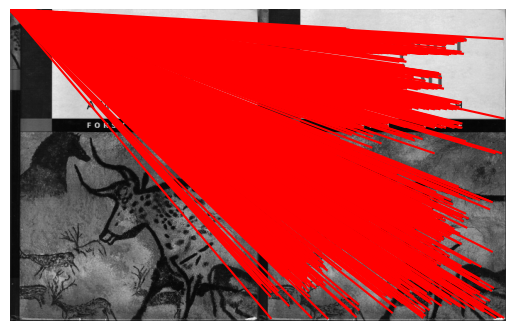

Plotting scale-invariant at scale: 1.50


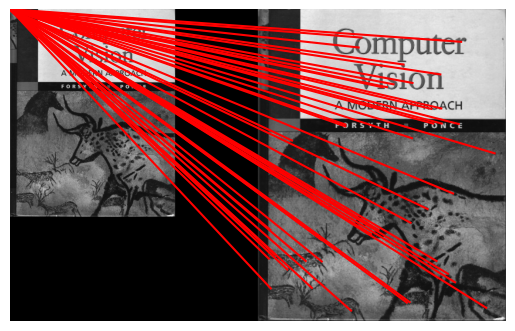

Analysis complete. Histogram generated.


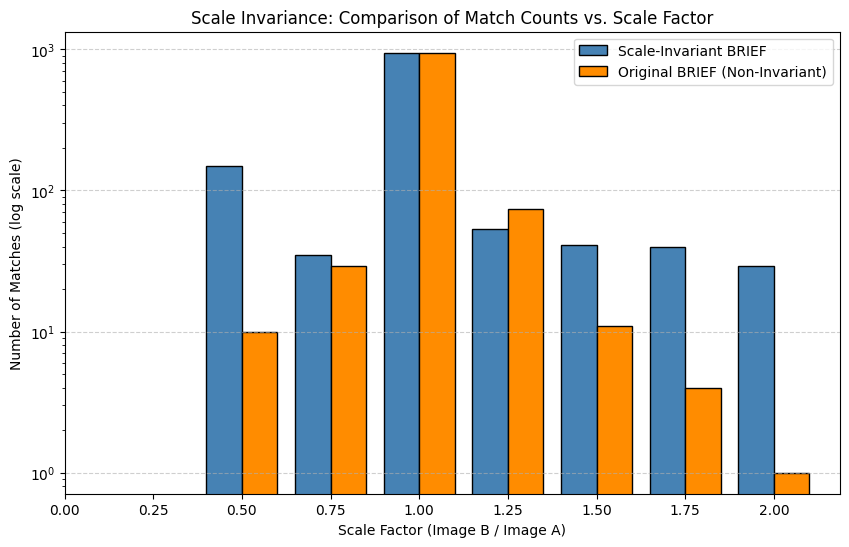

Comparative histogram saved to:
results/brief_scale_inv_histogram_comparison.png


In [ ]:


filename = 'hw3_data/cv_cover.jpg'
ratio = 0.7
sigma = 0.15
RES_DIR = 'results'

os.makedirs(RES_DIR, exist_ok=True)


try:
    print("Running briefScaleInvEc... (this may take a few minutes)")


    match_scales, counts_scale_inv, counts_orig = briefScaleInvEc(
        min_scale=0.5, max_scale=2.0, num_steps=7,
        ratio=ratio, sigma=sigma, filename=filename
    )

    if match_scales is not None:
        print("Analysis complete. Histogram generated.")

        plt.figure(figsize=(10, 6))

        bar_interval = match_scales[1] - match_scales[0] if len(match_scales) > 1 else 0.25
        bar_width = 0.4 * bar_interval

        plt.bar(
            np.array(match_scales) - bar_width/2,
            counts_scale_inv,
            width=bar_width,
            color='steelblue',
            edgecolor='black',
            label='Scale-Invariant BRIEF'
        )

        plt.bar(
            np.array(match_scales) + bar_width/2,
            counts_orig,
            width=bar_width,
            color='darkorange',
            edgecolor='black',
            label='Original BRIEF (Non-Invariant)'
        )

        plt.yscale('log')
        plt.title('Scale Invariance: Comparison of Match Counts vs. Scale Factor')
        plt.xlabel('Scale Factor (Image B / Image A)')
        plt.ylabel('Number of Matches (log scale)')
        plt.legend()
        plt.xticks(np.arange(0, 2.1, 0.25))
        plt.grid(axis='y', linestyle='--', alpha=0.6)

        histogram_path = os.path.join(RES_DIR, 'brief_scale_inv_histogram_comparison.png')

        plt.show()

        print(f"Comparative histogram saved to:\n{histogram_path}")

except Exception as e:
    print(f"Error while running briefScaleInvEc:\n{e}")

---

Explain your scale invariant design and how you selected any parameters that you used: YOUR ANSWER HERE...

The core design objective was to make the feature descriptor robust to changes in image size.

Image Pyramid Generation: The standard approach of detecting features on a single scale fails because keypoints become blurred or change neighborhood appearance when the image is resized. The fix is to explicitly detect features at multiple scales (resolutions) by creating several downsampled copies of the reference image. This ensures that a feature, regardless of its true size, is captured sharply at some level of the pyramid.


Features detected on a downsampled image (scale=1/2) are physically twice as large as those on the base image (scale=1).

We normalize all keypoint coordinates back to the original image's coordinate system by multiplying the coordinates by the scale factor (S). This effectively normalizes the feature's size and location, allowing a single matching process to compare features of different sizes correctly.

**Parameters**

Number of Octaves (NUM_OCTAVES):	4:	This determines the depth of the scale space. Four octaves provide a sufficient range to robustly capture features that vary significantly in size,

Scale Factor (SCALE_FACTOR)	:1.414 :	This defines the resize ratio between levels (octaves). Using  this
  is standard practice

Scaled Threshold :(σ
scaled
​
 )	σ×S:	The corner detection threshold (σ) must be adapted for each pyramid level (S). We scale the threshold by the level factor to normalize the detector's sensitivity.

Rescaling Method:	The INTER_AREA interpolation method is used for downsampling because it provides anti-aliasing and minimizes information loss, resulting in a more stable, higher-quality downsampled image for feature detection.


---


##  Homography Computation

###

Implement the function computeH

In [ ]:
def computeH(x1, x2):
    """
    Compute the homography between two sets of points

    Input
    -----
    x1, x2: Sets of points

    Returns
    -------
    H2to1: 3x3 homography matrix that best transforms x2 to x1
    """

    if x1.shape != x2.shape:
        raise RuntimeError('number of points do not match')

    # ===== your code here! =====
    # TODO: Compute the homography between two sets of points
    N = x1.shape[0]
    # Check minimum required points
    if N < 4:
        raise ValueError("Homography requires at least 4 corresponding point pairs.")
    A = np.zeros((2 * N, 9))
    for i in range(N):
        # x1 = [x1i, y1i], x2 = [x2i, y2i]
        x1i, y1i = x1[i, 0], x1[i, 1]
        x2i, y2i = x2[i, 0], x2[i, 1]
        # Row 2i :
        A[2 * i] = [-x2i, -y2i, -1, 0, 0, 0, x1i * x2i, x1i * y2i, x1i]
        # Row 2i+1 :
        A[2 * i + 1] = [0, 0, 0, -x2i, -y2i, -1, y1i * x2i, y1i * y2i, y1i]
 # Solve A * h = 0 using SVD.
    U, S, Vh = np.linalg.svd(A)
    h = Vh[-1, :]     # last row of V^T (smallest singular value)
    H2to1 = h.reshape(3, 3)

    # ==== end of code ====

    return H2to1

###

Implement the function computeH_norm

In [ ]:
def computeH_norm(x1, x2):
    """
    Compute the homography between two sets of points using normalization

    Input
    -----
    x1, x2: Sets of points

    Returns
    -------
    H2to1: 3x3 homography matrix that best transforms x2 to x1
    """

    # ===== your code here! =====
    N = x1.shape[0]

    # TODO: Compute the centroid of the points
    cx1, cy1 = np.mean(x1, axis=0)
    cx2, cy2 = np.mean(x2, axis=0)


    # TODO: Shift the origin of the points to the centroid
    x1_shifted = x1 - np.array([cx1, cy1])
    x2_shifted = x2 - np.array([cx2, cy2])


    # TODO: Normalize the points so that the largest distance from the
    # origin is equal to sqrt(2)
    distances1 = np.sqrt(x1_shifted[:, 0]**2 + x1_shifted[:, 1]**2)
    d_max_1 = np.max(distances1)
    distances2 = np.sqrt(x2_shifted[:, 0]**2 + x2_shifted[:, 1]**2)
    d_max_2 = np.max(distances2)
    # Scaling factor s1 such that max distance is sqrt(2)
    s1 = np.sqrt(2) / d_max_1 if d_max_1 != 0 else 1.0
    s2 = np.sqrt(2) / d_max_2 if d_max_2 != 0 else 1.0


    # TODO: Similarity transform 1
    T1 = np.array([
        [s1, 0, -s1 * cx1],
        [0, s1, -s1 * cy1],
        [0, 0, 1]
    ])


    # TODO: Similarity transform 2
    T2 = np.array([
        [s2, 0, -s2 * cx2],
        [0, s2, -s2 * cy2],
        [0, 0, 1]
    ])
     # Convert x1/x2 to homogeneous coordinates (3xN)
    x1_h = np.hstack((x1, np.ones((N, 1)))).T
    x2_h = np.hstack((x2, np.ones((N, 1)))).T
    x1_norm_h = T1 @ x1_h
    x2_norm_h = T2 @ x2_h
    x1_norm_h = x1_norm_h[:2, :].T
    x2_norm_h = x2_norm_h[:2, :].T


    # TODO: Compute homography

    H2to1_hom = computeH(x1_norm_h, x2_norm_h)
    # Denormalization
    T1_inv = np.linalg.inv(T1)
    H2to1 = T1_inv @ H2to1_hom @ T2



    # ==== end of code ====

    return H2to1

###

Implement RANSAC

In [ ]:
def computeH_ransac(locs1, locs2, max_iters, inlier_tol):
    """
    Estimate the homography between two sets of points using ransac

    Input
    -----
    locs1, locs2: Lists of points
    max_iters: the number of iterations to run RANSAC for
    inlier_tol: the tolerance value for considering a point to be an inlier

    Returns
    -------
    bestH2to1: 3x3 homography matrix that best transforms locs2 to locs1
    inliers: indices of RANSAC inliers

    """

    # ===== your code here! =====

    # TODO:
    # Compute the best fitting homography using RANSAC
    # given a list of matching points locs1 and loc2
    N = locs1.shape[0]
    bestH2to1 = None
    best_inliers = np.zeros(N, dtype=int)
    max_inliers = 0

    homog1 = np.hstack([locs1, np.ones((N,1))]).T
    homog2 = np.hstack([locs2, np.ones((N,1))]).T
    for i in range(max_iters):
        idx = np.random.choice(N, 4)
        pts1 = locs1[idx, :]
        pts2 = locs2[idx, :]


        H2to1 = computeH_norm(pts1, pts2)

        proj = H2to1 @ homog2
        proj = proj / proj[2, :]

        proj = proj[:2,:].T

        errors = np.linalg.norm(proj - locs1, axis=1)
        inliers = errors < inlier_tol
        num_inliers = np.sum(inliers)

        if num_inliers > max_inliers:
            max_inliers = num_inliers
            bestH2to1 = H2to1
            best_inliers = inliers.astype(int)

    inlier_idx = np.where(best_inliers==1)[0]
    if len(inlier_idx) >= 4:
        bestH2to1 = computeH_norm(locs1[inlier_idx], locs2[inlier_idx])



    # ==== end of code ====

    return bestH2to1, best_inliers

#### Implement the function compositeH

In [ ]:
def compositeH(H2to1, template, img):
    """
    Returns the composite image.

    Input
    -----
    H2to1: Homography from image to template
    template: template image to be warped
    img: background image

    Returns
    -------
    composite_img: Composite image

    """


      # ===== your code here! =====
    # TODO: Create a composite image after warping the template image on top
    # of the image using the homography
    h, w, i = img.shape
    warped_template = cv2.warpPerspective(template, H2to1, (w, h))
    #convert to grayscale
    #Masking start
    warped_gray = cv2.cvtColor(warped_template, cv2.COLOR_RGB2GRAY)
    boolean_mask = warped_gray > 0
    mask = np.zeros_like(warped_gray, dtype=np.uint8)
    mask[boolean_mask] = 255
    mask_3d = np.dstack([mask] * 3)
    mask_float = mask_3d.astype(np.float64) / 255.0
    inv_mask_float = 1.0 - mask_float
    img_masked = (img * inv_mask_float).astype(np.uint8)

    warped_masked = (warped_template * mask_float).astype(np.uint8)

    # Combine the two
    composite_img = cv2.add(img_masked, warped_masked)



    # ==== end of code ====

    return composite_img

#### Implement the function warpImage

In [ ]:
def warpImage(ratio, sigma, max_iters, inlier_tol):
    """
    Warps hp_cover.jpg onto the book cover in cv_desk.png.

    Input
    -----
    ratio: ratio for BRIEF feature descriptor
    sigma: threshold for corner detection using FAST feature detector
    max_iters: the number of iterations to run RANSAC for
    inlier_tol: the tolerance value for considering a point to be an inlier

    """

    hp_cover = skimage.io.imread(os.path.join(DATA_DIR, 'hw3_data/hp_cover.jpg'))
    cv_cover = skimage.io.imread(os.path.join(DATA_DIR, 'hw3_data/cv_cover.jpg'))
    cv_desk = skimage.io.imread(os.path.join(DATA_DIR, 'hw3_data/cv_desk.png'))
    cv_desk = cv_desk[:, :, :3]

    # ===== your code here! =====

    # TODO: match features between cv_desk and cv_cover using matchPics
    matches, locs1, locs2 = matchPics(cv_cover, cv_desk, ratio, sigma)
    x1_yx = locs1[matches[:, 0]]# Select
    x2_yx = locs2[matches[:, 1]]
    x1 = x1_yx[:, ::-1] #Swap
    x2 = x2_yx[:, ::-1]

    # TODO: Scale matched pixels in cv_cover to size of hp_cover
    w_cover, h_cover = cv_cover.shape[1], cv_cover.shape[0]
    w_hp, h_hp = hp_cover.shape[1], hp_cover.shape[0]

    scale_x = w_cover / w_hp
    scale_y = h_cover / h_hp
    scale_matrix = np.array([[scale_x, 0, 0],
                             [0, scale_y, 0],
                             [0, 0, 1]])


    # TODO: Get homography by RANSAC using computeH_ransac
    H_desk_to_cover, inliers = computeH_ransac(x1, x2, max_iters, inlier_tol)
    H_cover_to_desk = np.linalg.inv(H_desk_to_cover)
    H2to1 = H_cover_to_desk @ scale_matrix

    # TODO: Overlay using compositeH to return composite_img
    composite_img = compositeH(H2to1, hp_cover, cv_desk)


    plt.imshow(composite_img)
    plt.show()


#### Visualize composite image

/tmp/ipython-input-5728546.py:65: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return 1 if img[int(center[0]+row1)][int(center[1]+col1)] < img[int(center[0]+row2)][int(center[1]+col2)] else 0


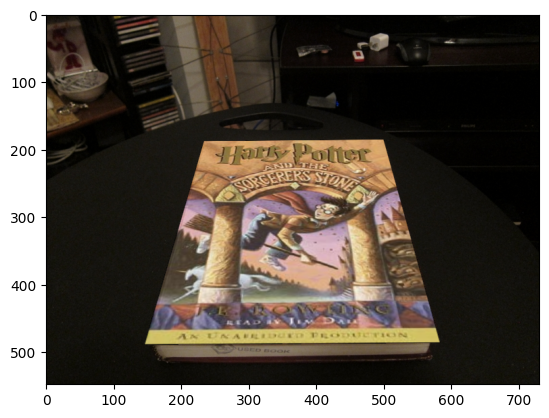

In [ ]:
# defaults are:
# ratio = 0.7
# sigma = 0.15
# max_iters = 600
# inlier_tol = 1.0

# (no need to change this but can if you want to experiment)
ratio = 0.7
sigma = 0.15
max_iters = 600
inlier_tol = 1.0

warpImage(ratio, sigma, max_iters, inlier_tol)

###

Conduct ablation study with various max_iters and inlier_tol values. Plot the result images and explain the effect of these two parameters respectively.

Case 1: max_iters = 50


/tmp/ipython-input-5728546.py:65: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return 1 if img[int(center[0]+row1)][int(center[1]+col1)] < img[int(center[0]+row2)][int(center[1]+col2)] else 0


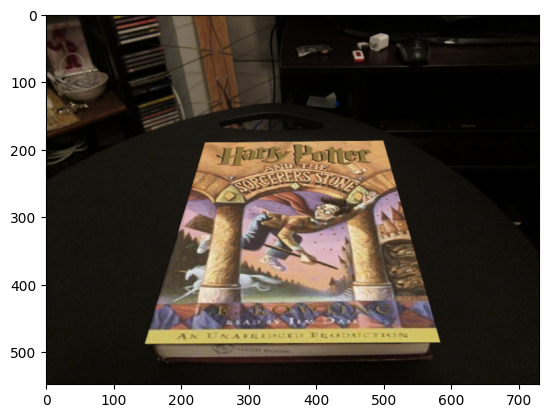

Case 2: max_iters = 600 


/tmp/ipython-input-5728546.py:65: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return 1 if img[int(center[0]+row1)][int(center[1]+col1)] < img[int(center[0]+row2)][int(center[1]+col2)] else 0


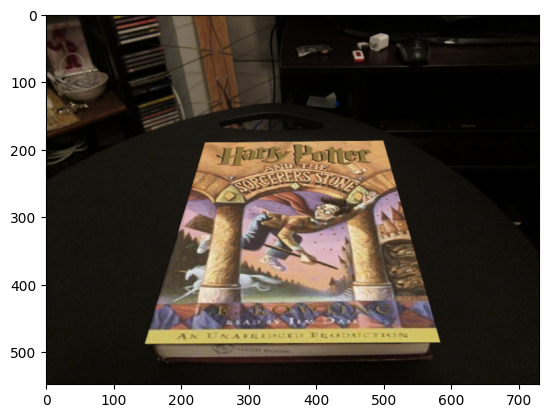

Case 3: max_iters = 2000


/tmp/ipython-input-5728546.py:65: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return 1 if img[int(center[0]+row1)][int(center[1]+col1)] < img[int(center[0]+row2)][int(center[1]+col2)] else 0


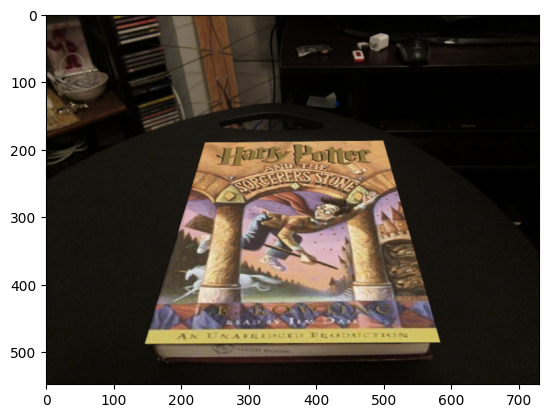

Case 4: inlier_tol = 0.8


/tmp/ipython-input-5728546.py:65: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return 1 if img[int(center[0]+row1)][int(center[1]+col1)] < img[int(center[0]+row2)][int(center[1]+col2)] else 0


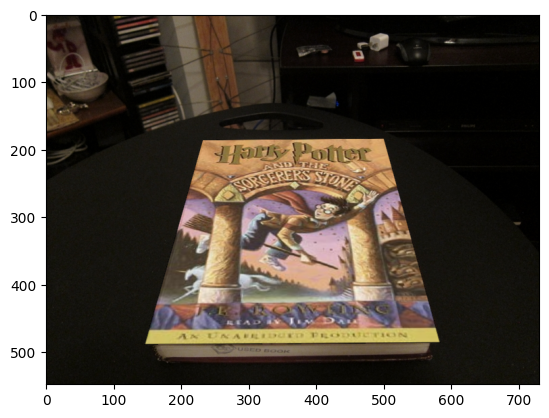

Case 5: inlier_tol = 3.0 


/tmp/ipython-input-5728546.py:65: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return 1 if img[int(center[0]+row1)][int(center[1]+col1)] < img[int(center[0]+row2)][int(center[1]+col2)] else 0


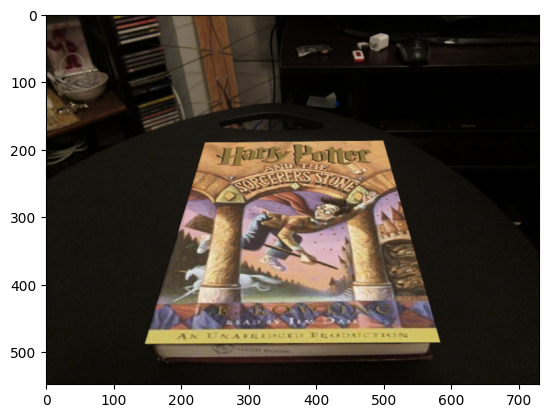

Case 6: inlier_tol = 10.0


/tmp/ipython-input-5728546.py:65: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return 1 if img[int(center[0]+row1)][int(center[1]+col1)] < img[int(center[0]+row2)][int(center[1]+col2)] else 0


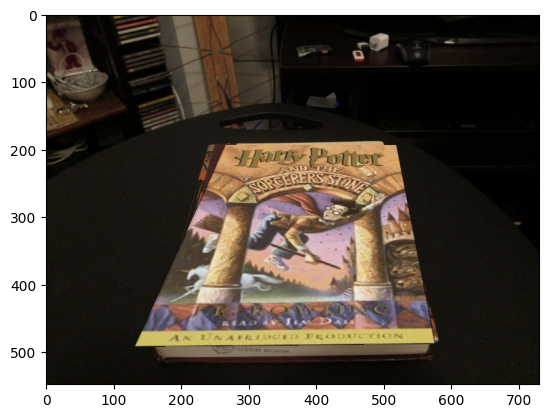

In [ ]:
# ===== your code here! =====
# Experiment with different max_iters and inlier_tol values.
# Include the result images in the write-up.
print("Case 1: max_iters = 50")
warpImage(ratio=0.7, sigma=0.15, max_iters=50, inlier_tol=3.0)


print("Case 2: max_iters = 600 ")
warpImage(ratio=0.7, sigma=0.15, max_iters=600, inlier_tol=3.0)


print("Case 3: max_iters = 2000")
warpImage(ratio=0.7, sigma=0.15, max_iters=2000, inlier_tol=3.0)


print("Case 4: inlier_tol = 0.8")
warpImage(ratio=0.7, sigma=0.15, max_iters=600, inlier_tol=0.8)

print("Case 5: inlier_tol = 3.0 ")
warpImage(ratio=0.7, sigma=0.15, max_iters=600, inlier_tol=3.0)


print("Case 6: inlier_tol = 10.0")
warpImage(ratio=0.7, sigma=0.15, max_iters=600, inlier_tol=10.0)

# ==== end of code ====

---

Explain the effect of max_iters and inlier_tol: YOUR ANSWER HERE...

**Effect of max_iters (Maximum Iterations)** (50-2000)

The max_iters parameter controls the number of times RANSAC randomly samples a minimal set of data points  to estimate a model.

Effect of a Low max_iters:

1)Faster execution time.

2)Low probability of finding the true model. If the dataset has a high percentage of outliers, the random sampling is likely to pick an outlier-contaminated minimal set. The resulting homography will be inaccurate.

Effect of a High max_iters:

1)Slower execution time.

2)Higher probability of randomly selecting a pure inlier minimal set. This increases the confidence that the estimated homography is accurate and robust to outliers.


**Effect of inlier_tol (Inlier Tolerance)**(0.8 to 10)
The inlier_tol parameter defines the maximum acceptable reprojection error for a data point to be considered an inlier to the currently hypothesized model.

Effect of a Low inlier_tol:

1) Only high-quality, very close matches are kept.	Higher Precision. H is estimated using only the most reliable data.

Risk: If the tolerance is too strict, even valid matches with slight localization noise might be rejected.

Effect of a High inlier_tol:

1) Larger inlier tolerance, potentially including some low-quality or minor outlier matches.
The final homography might be less precise, as it is biased by the inclusion of near-outliers. However, it is more stable because the model is based on a large number of points.

Risk: If the tolerance is too large, it might accept genuine outliers that are near the threshold, leading to a warped or incorrect global homograph.

---

#  a Simple Panorama

## Create a panorama

#### Implement the function createPanorama

In [ ]:
def createPanorama(left_im, right_im, ratio, sigma, max_iters, inlier_tol):
    """
    Create a panorama augmented reality application by computing a homography
    and stitching together a left and right image.

    Input
    -----
    left_im: left image
    right_im: right image
    ratio: ratio for BRIEF feature descriptor
    sigma: threshold for corner detection using FAST feature detector
    max_iters: the number of iterations to run RANSAC for
    inlier_tol: the tolerance value for considering a point to be an inlier

    Returns
    -------
    panorama_im: Stitched together panorama

    """

    # ===== your code here! =====
    # TODO: match features between images
    # This can be done using matchPics, cpselect, or any other function.
    matches, locs1, locs2 = matchPics(left_im,right_im, ratio, sigma)

    # TODO: Get homography by RANSAC using computeH_ransac
    x1_yx = locs1[matches[:, 0]]# Select
    x2_yx = locs2[matches[:, 1]]
    x1 = x1_yx[:, ::-1] #Swap
    x2 = x2_yx[:, ::-1]
    H_left_to_right, inliers = computeH_ransac(x2,x1, max_iters, inlier_tol)
    #Left Image
    left_shape = left_im.shape
    h_left = left_shape[0]
    w_left = left_shape[1]

    # Right Image
    right_shape = right_im.shape
    h_right = right_shape[0]
    w_right = right_shape[1]

    corners_left = np.array([[0, w_left, w_left, 0], [0, 0, h_left, h_left], [1, 1, 1, 1]])
    # make the image warped
    proj_left = H_left_to_right @ corners_left
    proj_left = proj_left / proj_left[2, :]

    coords_float = proj_left[:2, :]
    proj_corners=coords_float.astype(int)

    # define coordinate system
    x_min_warp = np.min(proj_left[0, :])
    x_max_warp = np.max(proj_left[0, :])
    y_min_warp = np.min(proj_left[1, :])
    y_max_warp = np.max(proj_left[1, :])
    x_min_pano = min(0, x_min_warp)
    x_max_pano = max(w_right, x_max_warp)
    y_min_pano = min(0, y_min_warp)
    y_max_pano = max(h_right, y_max_warp)
    #translate the vector
    dx_float = -x_min_pano
    dy_float = -y_min_pano
    dx = int(dx_float)
    dy = int(dy_float)

    w_pano = x_max_pano - x_min_pano
    h_pano = y_max_pano - y_min_pano
    w_pano = int(w_pano)
    h_pano = int(h_pano)

    T = np.array([[1, 0, dx],[0, 1, dy],[0, 0, 1]]) # transformation matrix

    H_final_warp = T @ H_left_to_right

    # TODO: Stich together the two images
    # Requires the use of cv2.warpPerspective

    panorama_im = np.zeros((h_pano, w_pano, right_im.shape[2]), dtype=np.uint8)
    panorama_im[dy:dy + h_right, dx:dx + w_right]= right_im

    #Warp left image and mask
    warped_left = cv2.warpPerspective(left_im, H_final_warp, (w_pano, h_pano))

    warped_left_gray = cv2.cvtColor(warped_left, cv2.COLOR_RGB2GRAY)
    boolean_mask = warped_left_gray > 0
    mask_left = np.zeros_like(warped_left_gray, dtype=np.uint8)
    mask_left[boolean_mask] = 255

    mask_3d = np.dstack([mask_left] * left_im.shape[2])
    mask_float = mask_3d.astype(np.float64) / 255.0
    inv_mask_float = 1.0 - mask_float


    right_only_area = (panorama_im * inv_mask_float).astype(np.uint8)

    left_only_area = (warped_left * mask_float).astype(np.uint8)

    # Combine:  RIGHT_ONLY_AREA + LEFT_CONTENT_AREA
    panorama_im = cv2.add(right_only_area, left_only_area)

    # ==== end of code ====

    return panorama_im.astype(np.uint8)

#### Visualize Panorama

Make sure to use **your own images** and **include them as well as the result** in the report.

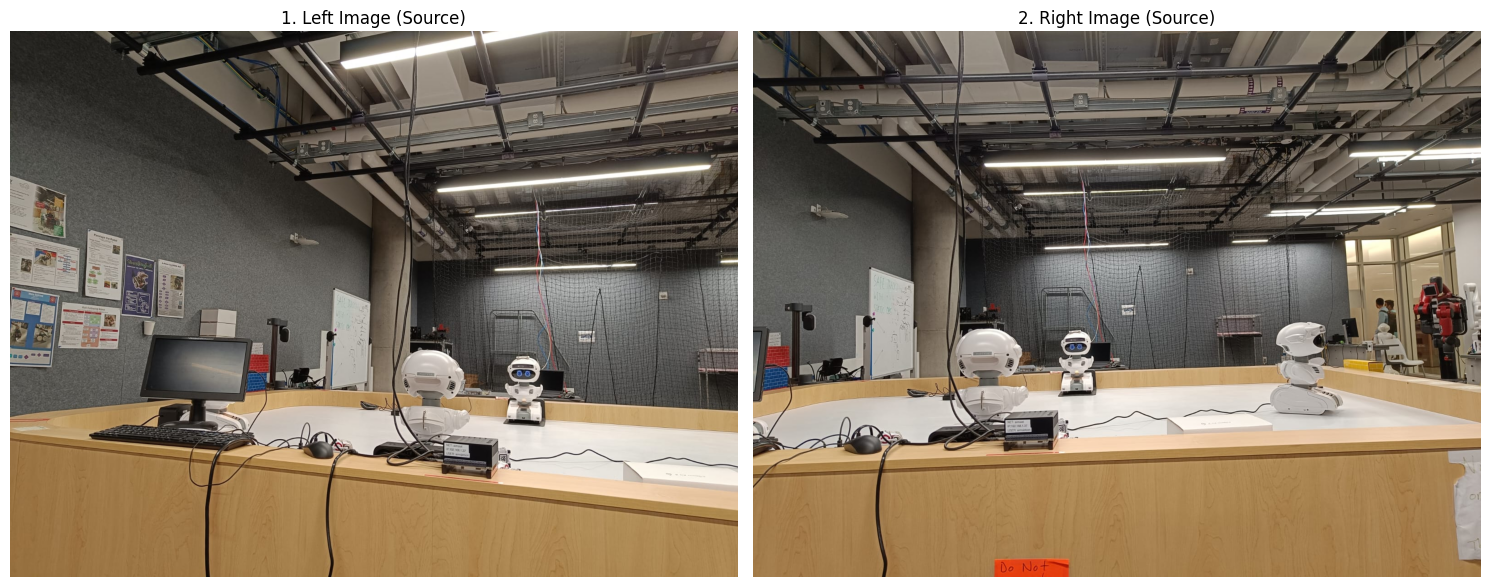

/tmp/ipython-input-5728546.py:65: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return 1 if img[int(center[0]+row1)][int(center[1]+col1)] < img[int(center[0]+row2)][int(center[1]+col2)] else 0


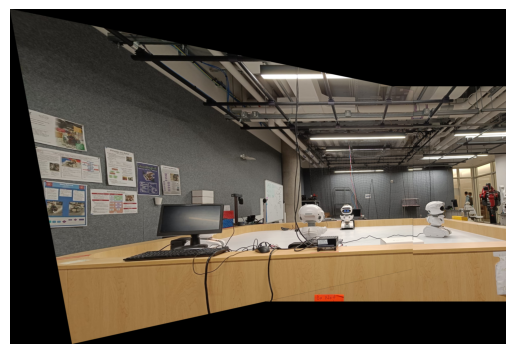

In [ ]:
left_im_path = os.path.join(DATA_DIR, '/content/WhatsApp Image 2025-10-06 at 4.55.27 PM.jpeg')
left_im = skimage.io.imread(left_im_path)
right_im_path = os.path.join(DATA_DIR, '/content/WhatsApp Image 2025-10-06 at 4.55.27 PM (1).jpeg')
right_im = skimage.io.imread(right_im_path)

# Feel free to adjust as needed
plt.figure(figsize=(15, 7)) # Adjust figure size for better viewing

# Subplot 1: Left Image
plt.subplot(1, 2, 1) # 1 row, 2 columns, position 1
plt.imshow(left_im)
plt.title('1. Left Image (Source)')
plt.axis('off')

# Subplot 2: Right Image
plt.subplot(1, 2, 2) # 1 row, 2 columns, position 2
plt.imshow(right_im)
plt.title('2. Right Image (Source)')
plt.axis('off')

plt.tight_layout() # Adjust spacing between subplots
plt.show()
ratio = 0.8
sigma = 0.15
max_iters = 2000
inlier_tol = 5

panorama_im = createPanorama(left_im, right_im, ratio, sigma, max_iters, inlier_tol)

plt.imshow(panorama_im)
plt.axis('off')
plt.show()

Code generates perfect panaroma for the images given in the question but for the images clicked by me it's distorted because I am not able to achieve perfect rotation of the camera